# Naive Bayes for Steering Classification

This notebook trains and evaluates Gaussian Naive Bayes on the steering image dataset.

**Key Concepts:**
- Uses Bayes' theorem with "naive" independence assumption
- Assumes features are conditionally independent given the class
- Fast training (O(n)) and prediction
- Works surprisingly well despite the unrealistic independence assumption


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print(f"\nRaw features shape: {X_raw.shape}")
print(f"Engineered features shape: {X_eng.shape}")


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}

Raw features shape: (9900, 4096)
Engineered features shape: (9900, 38)


In [3]:
# Preprocess data
# Note: Naive Bayes doesn't require scaling, but PCA helps with raw data dimensionality
print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False  # NB doesn't need scaling
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Train Gaussian Naive Bayes

Gaussian NB assumes continuous features follow a normal distribution within each class.


Training Gaussian Naive Bayes on RAW (PCA) features...

Model: Gaussian Naive Bayes | Features: raw
Accuracy:          0.8702
Balanced Accuracy: 0.7769
Macro F1:          0.7919
Weighted F1:       0.8661
Macro Precision:   0.8188
Macro Recall:      0.7769
ROC-AUC (macro):   0.9427

Per-class metrics:
  forward   : F1=0.9160, Precision=0.8943, Recall=0.9387
  left      : F1=0.7034, Precision=0.8285, Recall=0.6111
  right     : F1=0.7565, Precision=0.7337, Recall=0.7807

Classification Report:
              precision    recall  f1-score   support

     forward       0.89      0.94      0.92      1469
        left       0.83      0.61      0.70       324
       right       0.73      0.78      0.76       187

    accuracy                           0.87      1980
   macro avg       0.82      0.78      0.79      1980
weighted avg       0.87      0.87      0.87      1980



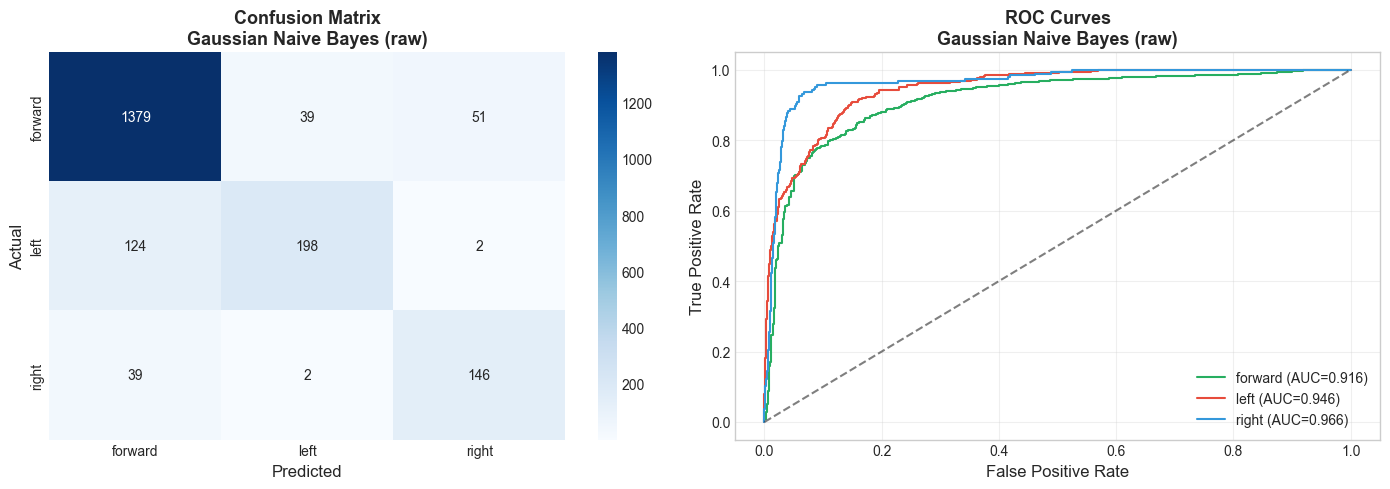

In [4]:
# Train Gaussian NB on RAW (PCA) features
print("Training Gaussian Naive Bayes on RAW (PCA) features...")

nb_raw = GaussianNB()
nb_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

results_nb_raw = evaluate_model(
    nb_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='Gaussian Naive Bayes',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Training Gaussian Naive Bayes on ENGINEERED features...

Model: Gaussian Naive Bayes | Features: engineered
Accuracy:          0.7192
Balanced Accuracy: 0.7268
Macro F1:          0.6389
Weighted F1:       0.7368
Macro Precision:   0.6067
Macro Recall:      0.7268
ROC-AUC (macro):   0.8761

Per-class metrics:
  forward   : F1=0.7919, Precision=0.8815, Recall=0.7189
  left      : F1=0.6222, Precision=0.5657, Recall=0.6914
  right     : F1=0.5026, Precision=0.3731, Recall=0.7701

Classification Report:
              precision    recall  f1-score   support

     forward       0.88      0.72      0.79      1469
        left       0.57      0.69      0.62       324
       right       0.37      0.77      0.50       187

    accuracy                           0.72      1980
   macro avg       0.61      0.73      0.64      1980
weighted avg       0.78      0.72      0.74      1980



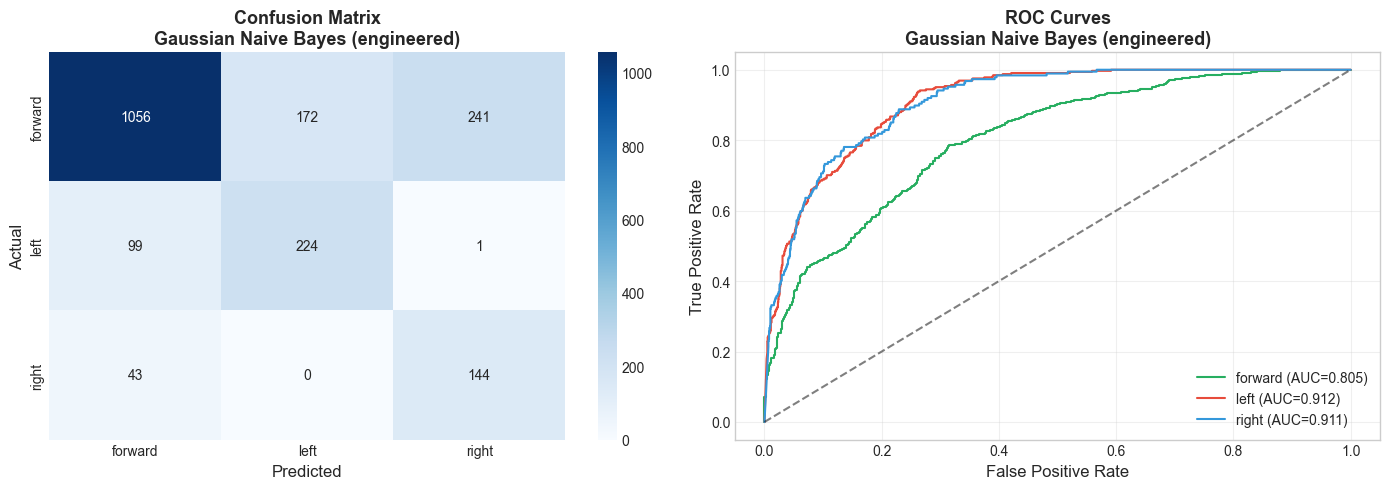

In [5]:
# Train Gaussian NB on ENGINEERED features
print("Training Gaussian Naive Bayes on ENGINEERED features...")

nb_eng = GaussianNB()
nb_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

results_nb_eng = evaluate_model(
    nb_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='Gaussian Naive Bayes',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 3. Analyze Learned Parameters


In [6]:
# Examine class priors learned from training data
print("Learned Class Priors (Engineered Features):")
print("="*50)
for i, cls in enumerate(CLASSES):
    print(f"  P({cls}) = {nb_eng.class_prior_[i]:.4f}")

# Show mean values for top features by class
print("\nFeature Means by Class (top 10 by variance across classes):")
print("="*50)

# Calculate variance of means across classes
mean_variance = np.var(nb_eng.theta_, axis=0)
top_features = np.argsort(mean_variance)[::-1][:10]

for idx in top_features:
    print(f"\n{feature_names[idx]}:")
    for i, cls in enumerate(CLASSES):
        print(f"  {cls}: mean={nb_eng.theta_[i, idx]:.4f}, var={nb_eng.var_[i, idx]:.4f}")


Learned Class Priors (Engineered Features):
  P(left) = 0.7417
  P(forward) = 0.1636
  P(right) = 0.0947

Feature Means by Class (top 10 by variance across classes):

lr_asymmetry:
  left: mean=-5.9376, var=940.2065
  forward: mean=39.2102, var=276.6514
  right: mean=-40.7591, var=262.1481

quad_tl_mean:
  left: mean=85.6514, var=732.7261
  forward: mean=111.9064, var=116.5723
  right: mean=59.8490, var=403.2987

quad_tr_mean:
  left: mean=95.9104, var=612.5619
  forward: mean=62.0460, var=322.5866
  right: mean=108.4301, var=120.0805

diag_asymmetry:
  left: mean=-8.6426, var=1442.1887
  forward: mean=21.3004, var=611.4861
  right: mean=-15.6440, var=805.0067

iqr:
  left: mean=34.8178, var=727.7222
  forward: mean=57.7878, var=1035.9490
  right: mean=68.4137, var=618.9128

quad_bl_mean:
  left: mean=112.3580, var=89.3338
  forward: mean=126.6017, var=217.4212
  right: mean=93.6358, var=105.2410

quad_br_mean:
  left: mean=113.9742, var=62.9284
  forward: mean=98.0417, var=142.1537
  

## 4. Results Summary


In [7]:
# Summary
all_results = [results_nb_raw, results_nb_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("NAIVE BAYES RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



NAIVE BAYES RESULTS SUMMARY
               Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
Gaussian Naive Bayes        raw  0.870202      0.776865    0.791942 0.942689
Gaussian Naive Bayes engineered  0.719192      0.726756    0.638914 0.876118


In [8]:
# Save results
save_results(all_results, 'naive_bayes')
print("Results saved successfully!")


Results saved to ../../data/model_results/naive_bayes_results.json
Results saved successfully!


## 5. Key Observations

### Why Naive Bayes Works
- Despite the obviously wrong independence assumption, NB often performs well
- The bias from wrong assumption may not hurt posterior probabilities much
- Fast training and prediction (O(n) complexity)

### Gaussian Assumption
- Assumes continuous features are normally distributed within each class
- May not hold perfectly for image data
- Works better when features have roughly Gaussian distributions

### Comparison with Other Methods
- Much faster than kNN (no distance computations at prediction time)
- Simpler than logistic regression (closed-form solution)
- May underperform when independence assumption is severely violated
